RDKit has multiple ways of creating the same fingerprint. Let's make sure they actually give the same result.

In [1]:
import numpy as np
import pandas as pd

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors, rdFingerprintGenerator

# Read in data and get an example SMILES

In [2]:
df = pd.read_csv('../examples/ESOL/data/delaney.csv')
df

,smiles,logSolubility
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770
1,Cc1occc1C(=O)Nc2ccccc2,-3.300
2,CC(C)=CCCC(C)=CC(=O),-2.060
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870
4,c1ccsc1,-1.330
...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106
1125,CCSCCSP(=S)(OC)OC,-3.091
1126,CCC(C)C,-3.180


In [3]:
smi = df.smiles.values[1]
smi

'Cc1occc1C(=O)Nc2ccccc2'

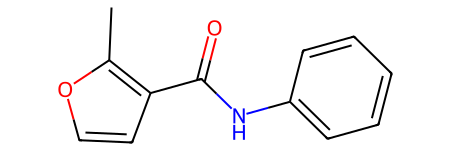

In [4]:
mol = Chem.MolFromSmiles(smi)
mol

In [5]:
def rdkit_to_np(vect, nbits):
    """Helper function to convert a sparse vector from RDKit to a dense numpy vector."""
    arr = np.zeros((nbits,))
    DataStructs.ConvertToNumpyArray(vect, arr)  # overwrites arr
    return arr

# Compare approaches to create a Morgan fingerprint

### Method 1:
https://github.com/kspieks/chemprop/blob/barrier_prediction/chemprop/features/features_generators.py#L53-L69

In [6]:
radius = 2
num_bits = 2048

In [7]:
# this creates a count vector
fp_count1 = AllChem.GetHashedMorganFingerprint(mol, radius, nBits=num_bits, useChirality=True)
fp_count1 = rdkit_to_np(fp_count1, num_bits)
fp_count1.shape, max(fp_count1)

((2048,), 7.0)

In [8]:
fp1 = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=num_bits, useChirality=True)
fp1 = rdkit_to_np(fp1, num_bits)
fp1.shape, max(fp1)

((2048,), 1.0)

### Method 2:
https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html

In [9]:
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=num_bits, includeChirality=True)

In [10]:
fp_count2 = morgan_gen.GetCountFingerprintAsNumPy(mol)
fp_count2.shape, max(fp_count2)

((2048,), 7)

In [11]:
all(fp_count1 == fp_count2)

True

In [12]:
fp2 = morgan_gen.GetFingerprintAsNumPy(mol)
fp2.shape, max(fp2)

((2048,), 1)

In [13]:
all(fp1 == fp2)

True

# Compare approaches to generate AtomPair fingerprint

### Method 1

https://www.rdkit.org/docs/source/rdkit.Chem.AtomPairs.Pairs.html

https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html#rdkit.Chem.rdMolDescriptors.GetHashedAtomPairFingerprint

https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html#rdkit.Chem.rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect

In [14]:
minPathLen = 1
maxPathLen = 30
nbits = 2048

In [15]:
# this creates a count fingerprint
fp_count1 = rdMolDescriptors.GetHashedAtomPairFingerprint(mol,
                                   minLength=minPathLen,
                                   maxLength=maxPathLen,
                                   nBits=nbits,
                                   includeChirality=True
                                  )
fp_count1 = rdkit_to_np(fp_count1, nbits)
fp_count1.shape, max(fp_count1)

((2048,), 8.0)

In [16]:
fp1 = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol,
                                   minLength=minPathLen,
                                   maxLength=maxPathLen,
                                   nBits=nbits,
                                   includeChirality=True,
                                  )
fp1 = rdkit_to_np(fp1, nbits)
fp1.shape, max(fp1)

((2048,), 1.0)

### Method 2

https://www.rdkit.org/docs/source/rdkit.Chem.rdFingerprintGenerator.html#rdkit.Chem.rdFingerprintGenerator.GetAtomPairGenerator

In [17]:
atompair_gen = rdFingerprintGenerator.GetAtomPairGenerator(
        minDistance=minPathLen,
        maxDistance=maxPathLen,
        fpSize=nbits,
        includeChirality=True,
)

In [18]:
fp_count2 = atompair_gen.GetCountFingerprintAsNumPy(mol)
fp_count2.shape, max(fp_count2)

((2048,), 8)

In [19]:
all(fp_count1 == fp_count2)

True

In [20]:
fp2 = atompair_gen.GetFingerprintAsNumPy(mol)
fp2.shape, max(fp2)

((2048,), 1)

In [21]:
all(fp1 == fp2)

True